In [1]:
import pandas as pd
pd.set_option('mode.chained_assignment', None)
import numpy as np
from numpy import nan
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('dark')

import warnings
warnings.filterwarnings('ignore')

# import torch
# from torch import nn
# from torchvision import models
# from torch.utils.data import Dataset
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import platform
import sys
import os
import sklearn 
import cv2
import json
from glob import glob

print(f"- os: {platform.platform()}")
print(f"- python: {sys.version}")
print(f"- pandas: {pd.__version__}")
print(f"- numpy: {np.__version__}")
print(f"- sklearn: {sklearn.__version__}")
# print(f"- pytorch: {torch.__version__}")
print(f"- opencv: {cv2.__version__}")

- os: Windows-10-10.0.22000-SP0
- python: 3.7.11 (default, Jul 27 2021, 09:42:29) [MSC v.1916 64 bit (AMD64)]
- pandas: 1.3.5
- numpy: 1.19.5
- sklearn: 0.23.2
- opencv: 4.5.5


In [2]:
from pycaret.classification import * 

# csv분석

In [3]:
TRAIN_PATH = 'C:/Users/jeong/Projects/dacon/병해진단/data/train/'
TEST_PATH = 'C:/Users/jeong/Projects/dacon/병해진단/data/test/'
DATASET_NAME = 'CROP_DISEASE_5folds'
BATCH_SIZE = 128
EPOCHS = 150
USE_FOLD = True
SEED = 42
NUM_FOLD = 2

FLIP_IMG = True
BLUR_IMG = True
USE_AIHUB_DATA = False

# image resize
IMG_SIZE = 128

In [4]:
train_csv = sorted(glob(TRAIN_PATH +'*/*.csv'))
train_json = sorted(glob(TRAIN_PATH +'*/*.json'))

test_csv = sorted(glob(TEST_PATH +'*/*.csv'))
test_json = sorted(glob(TEST_PATH +'*/*.json'))

In [5]:
def json_data_load(train_json):
    crops = []
    areas = []
    diseases = []
    risks = []
    labels = []
    img_names = []
    parts=[]
    objects = []
    img_w = []
    img_h = []
    grows = []
    img_dirs = []
    for i in range(len(tqdm(train_json))):
        with open(train_json[i], 'r') as f:
            sample = json.load(f)
            
            crop = sample['annotations']['crop']
            area = sample['annotations']['area']
            disease = sample['annotations']['disease']
            grow = sample['annotations']['grow']
            risk = sample['annotations']['risk']
            label=f"{crop}_{disease}_{risk}"        
            img_name = sample['description']['image'].replace('.jpg','')
            img_dir = train_json[i].replace('.json', '.jpg')
            width = sample['description']['width']
            height = sample['description']['height']

            crops.append(crop)
            areas.append(area)
            diseases.append(disease)
            risks.append(risk)
            labels.append(label)
            img_names.append(img_name)
            img_w.append(width)
            img_h.append(height)
            img_dirs.append(img_dir)
            grows.append(grow)
            r = sample['annotations']['bbox'][0]
            temp = [int(r['x']), int(r['y']), int(r['w']), int(r['h'])]
            objects.append(temp)    
            
            p = []
            
            for part in sample['annotations']['part']:
                p.append([int(part['x']), int(part['y']), int(part['w']), int(part['h'])])
            parts.append(p)

    df = pd.DataFrame({'image':img_names, 'img_w':img_w, 'img_h':img_h, 'crops':crops,'areas':areas,'diseases':diseases,'risks':risks, 
                       'grows':grows, 'bbox':objects, 'parts':parts, 'labels':labels, 'dir':img_dirs})
    df['crop_area'] = df.crops.astype(str) + '_' + df.areas.astype(str)
    df['disease_risk'] = df.diseases.astype(str) + '_' + df.risks.astype(str)

    df['x'] = df.bbox.apply(lambda x: x[0])
    df['y'] = df.bbox.apply(lambda x: x[1])
    df['w'] = df.bbox.apply(lambda x: x[2])
    df['h'] = df.bbox.apply(lambda x: x[3])
    df['xc'] = df.x + df.w.apply(lambda x:x//2)
    df['yc'] = df.y + df.h.apply(lambda x:x//2)
    
    df.dir = df.dir.apply(lambda x: x.replace('\\','/'))
    df = df[['image','crops','areas','diseases','risks','grows','xc','yc','w','h', 'img_w', 'img_h', 'parts', 'dir']]

    return df

In [6]:
from datetime import datetime, timedelta
def get_df_csv(csv_dir):

    df_csv = pd.DataFrame(columns={'image','month','mean_temp', 'high_temp', 'low_temp', 'mean_humi', 'high_humi', 'low_humi',  
                                    'mean_dew', 'high_dew', 'low_dew', 'temp_cond_1','temp_cond_2','temp_cond_3','temp_cond_4',
                                    'humidity_70','humidity_80','humidity_90','humidity_95',
                                    'RH_70','RH_95','RH_100'})

    for i, csv in enumerate(tqdm(csv_dir)):
        data = pd.read_csv(f'{csv}')
        data = data[['측정시각', '내부 온도 1 평균', '내부 온도 1 최고', '내부 온도 1 최저','내부 습도 1 평균', '내부 습도 1 최고',
           '내부 습도 1 최저','내부 이슬점 평균', '내부 이슬점 최고', '내부 이슬점 최저']]
        data = data.drop_duplicates(subset=['측정시각'])
        # data = data.sort_values(by='측정시각')
        data['측정시각'] = data['측정시각'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
        data = data.replace('0', np.nan).dropna()
        data = data.replace('-', np.nan).dropna()
        

        img_name = csv_dir[i].split('\\')[-1].replace('.csv','')
        month = data.측정시각.dt.month.mean()
        lenth = len(data)

        mean_temp = data['내부 온도 1 평균'].astype(float).median()
        high_temp = data['내부 온도 1 최고'].astype(float).max()
        low_temp = data['내부 온도 1 최저'].astype(float).min()
        mean_humi = data['내부 습도 1 평균'].astype(float).median()
        high_humi = data['내부 습도 1 최고'].astype(float).max()
        low_humi = data['내부 습도 1 최저'].astype(float).min()
        mean_dew = data['내부 이슬점 평균'].astype(float).median()
        high_dew = data['내부 이슬점 최고'].astype(float).max()
        low_dew = data['내부 이슬점 최저'].astype(float).min()

        temp_cond_1 = len(data[(data['내부 온도 1 평균']>=20)&(data['내부 온도 1 평균']<=25)])/lenth
        temp_cond_2 = len(data[(data['내부 온도 1 평균']<=13)])/lenth
        temp_cond_3 = len(data[(data['내부 온도 1 평균']>=32) & (data['내부 온도 1 최고']<35)])/lenth
        temp_cond_4 = len(data[(data['내부 온도 1 평균']>=35)])/lenth

        humidity_70 = len(data[(data['내부 습도 1 평균']>=70)& (data['내부 습도 1 평균']<80)])/lenth
        humidity_80 = len(data[(data['내부 습도 1 평균']>=80)& (data['내부 습도 1 평균']<90)])/lenth
        humidity_90 = len(data[(data['내부 습도 1 평균']>=90)& (data['내부 습도 1 평균']<95)])/lenth
        humidity_95 = len(data[(data['내부 습도 1 평균']>=95)])/lenth

        TD = data['내부 이슬점 평균'].astype(float)
        T = data['내부 온도 1 평균'].astype(float)
        RH = 100*(np.exp((17.625*TD)/(243.04+TD))/np.exp((17.625*T)/(243.04+T)))

        RH_70 = len(RH[(RH>=70)& (RH<95)])/lenth
        RH_95 = len(RH[(RH>=95)& (RH<100)])/lenth
        RH_100 = len(RH[(RH>=100)])/lenth

        csv_series = pd.Series({'image':img_name, 'month':month,'mean_temp':mean_temp, 'high_temp':high_temp, 'low_temp':low_temp, 
                                'mean_humi':mean_humi, 'high_humi':high_humi, 'low_humi':low_humi,  
                                'mean_dew':mean_dew, 'high_dew':high_dew, 'low_dew':low_dew,
                                'temp_cond_1':temp_cond_1,'temp_cond_2':temp_cond_2,'temp_cond_3':temp_cond_3,'temp_cond_4':temp_cond_4,
                                'humidity_70':humidity_70,'humidity_80':humidity_80,'humidity_90':humidity_90,'humidity_95':humidity_95,
                                 'RH_70':RH_70,'RH_95':RH_95,'RH_100':RH_100})
        df_csv.loc[i] = csv_series
    return df_csv


In [7]:
df_train = json_data_load(train_json)
csv_train = get_df_csv(train_csv)
csv_test = get_df_csv(test_csv)

print(len(csv_train))
print(len(csv_test))
csv_train

100%|████████████████████████████████████████████████████████████████████████████| 51906/51906 [16:37<00:00, 52.05it/s]

5767
51906


,low_dew,mean_humi,humidity_95,high_humi,month,RH_95,high_dew,RH_70,temp_cond_1,RH_100,high_temp,humidity_90,temp_cond_3,mean_temp,image,humidity_70,temp_cond_4,low_temp,mean_dew,temp_cond_2,humidity_80,low_humi
0,1.7,83.70,0.000000,92.4,11.000000,0.000000,11.0,0.755102,0.000000,0.000000,18.7,0.064626,0.000000,9.35,10027,0.115646,0.000000,4.9,6.60,0.717687,0.578231,39.6
1,14.1,83.40,0.000000,94.9,9.000000,0.064626,22.1,0.642857,0.292517,0.000000,30.7,0.210884,0.000000,22.10,10037,0.146259,0.000000,16.9,19.45,0.000000,0.350340,49.9
2,15.2,80.80,0.000000,94.6,6.000000,0.027211,21.3,0.741497,0.408163,0.000000,29.6,0.282313,0.000000,22.00,10043,0.244898,0.000000,16.9,17.60,0.000000,0.251701,43.0
3,13.7,83.35,0.000000,93.6,9.000000,0.003401,21.3,0.632653,0.217687,0.000000,29.6,0.163265,0.000000,20.90,10045,0.081633,0.000000,15.1,17.60,0.000000,0.391156,49.9
4,15.2,80.80,0.000000,94.6,6.000000,0.027211,21.3,0.741497,0.408163,0.000000,29.6,0.282313,0.000000,22.00,10063,0.244898,0.000000,16.9,17.70,0.000000,0.251701,43.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5762,16.1,93.70,0.251701,96.4,9.000000,0.391156,22.4,0.530612,0.707483,0.000000,27.0,0.374150,0.000000,21.00,67640,0.095238,0.000000,17.1,19.70,0.000000,0.190476,64.5
5763,11.9,77.95,0.000000,90.6,9.000000,0.000000,21.9,0.571429,0.204082,0.000000,32.2,0.010204,0.000000,20.90,67644,0.081633,0.000000,14.3,17.20,0.000000,0.469388,45.8
5764,5.6,94.65,0.472789,99.5,10.000000,0.384354,34.0,0.517007,0.214286,0.040816,39.8,0.166667,0.057823,18.95,67647,0.139456,0.037415,6.3,17.20,0.248299,0.159864,51.7
5765,13.6,89.40,0.010204,95.8,10.000000,0.081633,25.6,0.588435,0.129252,0.000000,32.1,0.459184,0.000000,20.10,67649,0.071429,0.000000,15.3,18.00,0.000000,0.125850,45.2


In [8]:
df_train['label'] = df_train.crops.astype(str) +'_'+ df_train.diseases +'_'+ df_train.risks.astype(str)
train1 = pd.merge(df_train[['image','label']], csv_train, on='image', how='outer')
train2= pd.merge(df_train[['image','crops','label']], csv_train, on='image', how='outer')
train3= pd.merge(df_train[['image','crops','areas','grows','label']], csv_train, on='image', how='outer')

train1 = train1[['image','month','mean_temp', 'high_temp', 'low_temp', 'mean_humi', 'high_humi', 'low_humi',  
                'mean_dew', 'high_dew', 'low_dew', 'temp_cond_1','temp_cond_2','temp_cond_3','temp_cond_4',
                'humidity_70','humidity_80','humidity_90','humidity_95',
                'RH_70','RH_95','RH_100','label']]
train2 = train2[['image','crops','month','mean_temp', 'high_temp', 'low_temp', 'mean_humi', 'high_humi', 'low_humi',  
                'mean_dew', 'high_dew', 'low_dew', 'temp_cond_1','temp_cond_2','temp_cond_3','temp_cond_4',
                'humidity_70','humidity_80','humidity_90','humidity_95',
                'RH_70','RH_95','RH_100','label']]

train3 = train3[['image','crops','areas','grows','month','mean_temp', 'high_temp', 'low_temp', 'mean_humi',   
                'high_humi', 'low_humi','mean_dew', 'high_dew', 'low_dew', 'temp_cond_1','temp_cond_2',
                'temp_cond_3','temp_cond_4','humidity_70','humidity_80','humidity_90','humidity_95',
                'RH_70','RH_95','RH_100','label']]
train1

,image,month,mean_temp,high_temp,low_temp,mean_humi,high_humi,low_humi,mean_dew,high_dew,low_dew,temp_cond_1,temp_cond_2,temp_cond_3,temp_cond_4,humidity_70,humidity_80,humidity_90,humidity_95,RH_70,RH_95,RH_100,label
0,10027,11.000000,9.35,18.7,4.9,83.70,92.4,39.6,6.60,11.0,1.7,0.000000,0.717687,0.000000,0.000000,0.115646,0.578231,0.064626,0.000000,0.755102,0.000000,0.000000,3_b7_1
1,10037,9.000000,22.10,30.7,16.9,83.40,94.9,49.9,19.45,22.1,14.1,0.292517,0.000000,0.000000,0.000000,0.146259,0.350340,0.210884,0.000000,0.642857,0.064626,0.000000,3_00_0
2,10043,6.000000,22.00,29.6,16.9,80.80,94.6,43.0,17.60,21.3,15.2,0.408163,0.000000,0.000000,0.000000,0.244898,0.251701,0.282313,0.000000,0.741497,0.027211,0.000000,3_00_0
3,10045,9.000000,20.90,29.6,15.1,83.35,93.6,49.9,17.60,21.3,13.7,0.217687,0.000000,0.000000,0.000000,0.081633,0.391156,0.163265,0.000000,0.632653,0.003401,0.000000,3_00_0
4,10063,6.000000,22.00,29.6,16.9,80.80,94.6,43.0,17.70,21.3,15.2,0.408163,0.000000,0.000000,0.000000,0.244898,0.251701,0.282313,0.000000,0.741497,0.027211,0.000000,3_00_0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5762,67640,9.000000,21.00,27.0,17.1,93.70,96.4,64.5,19.70,22.4,16.1,0.707483,0.000000,0.000000,0.000000,0.095238,0.190476,0.374150,0.251701,0.530612,0.391156,0.000000,3_00_0
5763,67644,9.000000,20.90,32.2,14.3,77.95,90.6,45.8,17.20,21.9,11.9,0.204082,0.000000,0.000000,0.000000,0.081633,0.469388,0.010204,0.000000,0.571429,0.000000,0.000000,1_00_0
5764,67647,10.000000,18.95,39.8,6.3,94.65,99.5,51.7,17.20,34.0,5.6,0.214286,0.248299,0.057823,0.037415,0.139456,0.159864,0.166667,0.472789,0.517007,0.384354,0.040816,2_a5_2
5765,67649,10.000000,20.10,32.1,15.3,89.40,95.8,45.2,18.00,25.6,13.6,0.129252,0.000000,0.000000,0.000000,0.071429,0.125850,0.459184,0.010204,0.588435,0.081633,0.000000,1_00_0


In [14]:
csv_train.to_csv('./csv_train.csv', index=False)
csv_test.to_csv('./csv_test.csv', index=False)

In [9]:
train_img_names1 = train1.pop('image')
train_img_names2 = train2.pop('image')
train_img_names3 = train3.pop('image')
test_img_names = csv_test.pop('image')

In [10]:
X_test = csv_test

# search model

In [11]:
ignore_features = []
categorical_features = []
numerical_features = ['month','mean_temp', 'high_temp', 'low_temp', 'mean_humi', 'high_humi', 'low_humi',  
                        'mean_dew', 'high_dew', 'low_dew', 'temp_cond_1','temp_cond_2','temp_cond_3','temp_cond_4',
                        'humidity_70','humidity_80','humidity_90','humidity_95',
                            'RH_70','RH_95','RH_100']

In [25]:
clf = setup(data=train1, 
            target='label', 
            ignore_features=ignore_features,           
            categorical_features=categorical_features, 
            numeric_features=numerical_features,
#             remove_outliers=True,
#             outliers_threshold=0.1,
            normalize=True,                            
#             handle_unknown_categorical=True,
#             imputation_type='iterative',              
#             iterative_imputation_iters=10,            
#             categorical_iterative_imputer='lightgbm',
#             polynomial_features=True,
            session_id=SEED, 
            silent=True,
            feature_selection=True,
#             fix_imbalance=True,
#             remove_multicollinearity=True,
#             ignore_low_variance=True,
#             profile=True
            ) 

,Description,Value
0,session_id,42
1,Target,label
2,Target Type,Multiclass
3,Label Encoded,"1_00_0: 0, 2_00_0: 1, 2_a5_2: 2, 3_00_0: 3, 3_a9_1: 4, 3_a9_2: 5, 3_a9_3: 6, 3_b3_1: 7, 3_b6_1: 8, 3_b7_1: 9, 3_b8_1: 10, 4_00_0: 11, 5_00_0: 12, 5_a7_2: 13, 5_b6_1: 14, 5_b7_1: 15, 5_b8_1: 16, 6_00_0: 17, 6_a11_1: 18, 6_a11_2: 19, 6_a12_1: 20, 6_a12_2: 21, 6_b4_1: 22, 6_b4_3: 23, 6_b5_1: 24"
4,Original Data,"(5767, 22)"
5,Missing Values,False
6,Numeric Features,21
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [26]:
best_models = compare_models(sort='f1', n_select=3, fold=5, verbose=True) 

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.9477,0.9989,0.8661,0.9500,0.9457,0.9408,0.9410,1.0680
et,Extra Trees Classifier,0.9487,0.9967,0.8744,0.9512,0.9451,0.9419,0.9422,0.2000
catboost,CatBoost Classifier,0.9470,0.9989,0.8543,0.9490,0.9449,0.9400,0.9402,33.3100
dt,Decision Tree Classifier,0.9482,0.9958,0.8700,0.9508,0.9445,0.9414,0.9417,0.0100
rf,Random Forest Classifier,0.9487,0.9979,0.8715,0.9501,0.9443,0.9419,0.9423,0.2240
gbc,Gradient Boosting Classifier,0.9465,0.9977,0.8598,0.9485,0.9443,0.9394,0.9396,3.5960
knn,K Neighbors Classifier,0.9400,0.9919,0.8367,0.9447,0.9342,0.9321,0.9326,0.0580
lr,Logistic Regression,0.8974,0.9957,0.7633,0.8978,0.8848,0.8837,0.8849,0.4180
lightgbm,Light Gradient Boosting Machine,0.8664,0.9550,0.7551,0.8870,0.8703,0.8510,0.8532,1.3680
svm,SVM - Linear Kernel,0.8712,0.0000,0.7085,0.8592,0.8553,0.8537,0.8563,0.0300


In [27]:
ctuned_top3 = [tune_model(model, fold=5, optimize='F1') for model in best_models]#, choose_better=True

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9468,0.9987,0.8225,0.9428,0.9394,0.9398,0.9402
1,0.9442,0.9987,0.8341,0.9401,0.9417,0.9368,0.9369
2,0.9430,0.9988,0.8274,0.9366,0.9357,0.9354,0.9359
3,0.9492,0.9988,0.8218,0.9530,0.9475,0.9424,0.9427
4,0.9393,0.9985,0.8195,0.9373,0.9372,0.9313,0.9313
Mean,0.9445,0.9987,0.8251,0.9419,0.9403,0.9371,0.9374
SD,0.0034,0.0001,0.0052,0.0059,0.0041,0.0038,0.0039


# learning curve

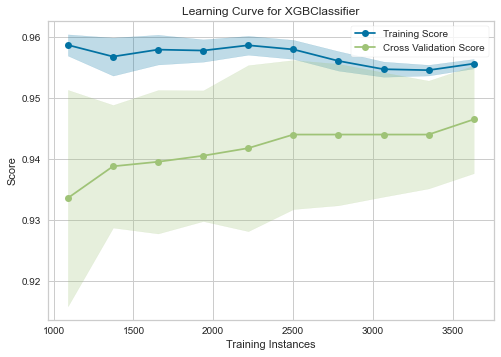

In [28]:
plot_model(tuned_top3[0], plot='learning')

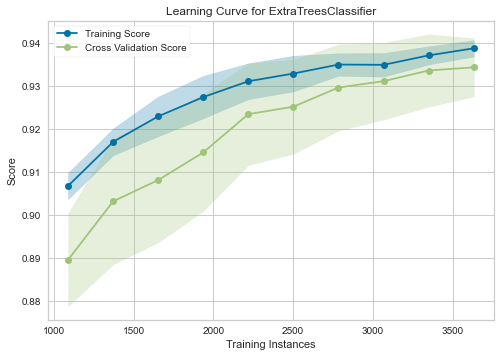

In [29]:
plot_model(tuned_top3[1], plot='learning')

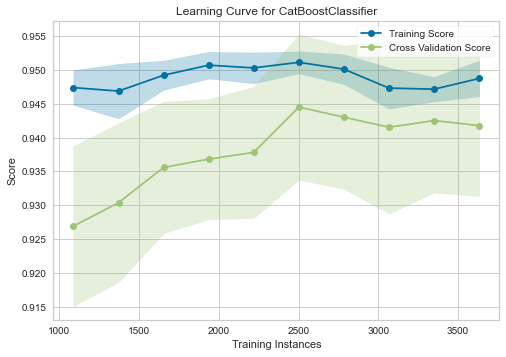

In [30]:
plot_model(tuned_top3[2], plot='learning')

# confusion matrix

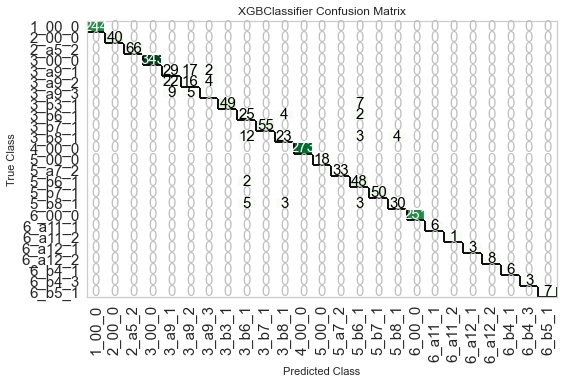

In [31]:
plot_model(tuned_top3[0], plot='confusion_matrix')

# features

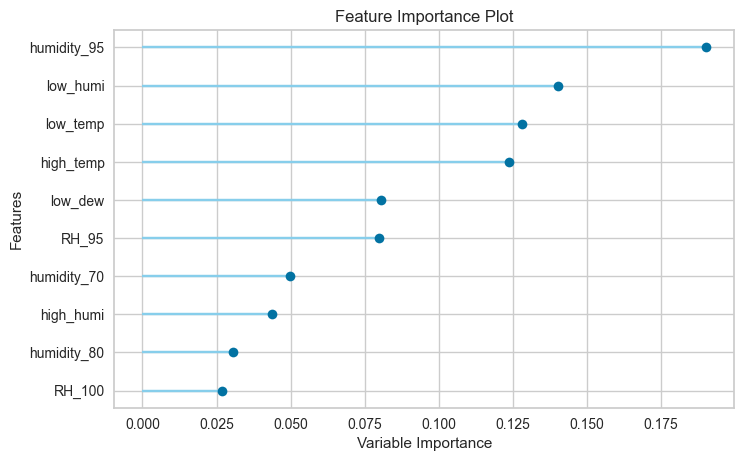

In [44]:
plot_model(tuned_top3[0], plot='feature')

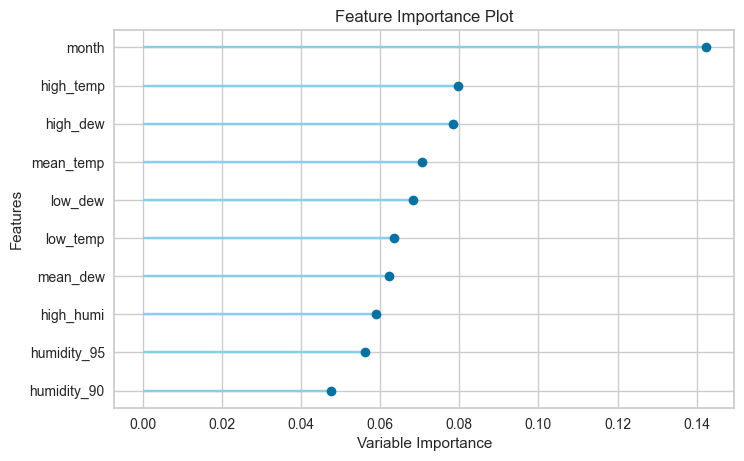

In [45]:
plot_model(tuned_top3[1], plot='feature')

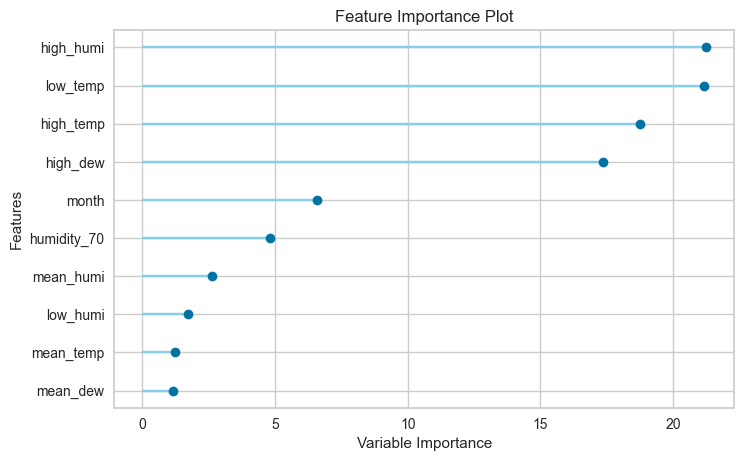

In [46]:
plot_model(tuned_top3[2], plot='feature')

# auc curve

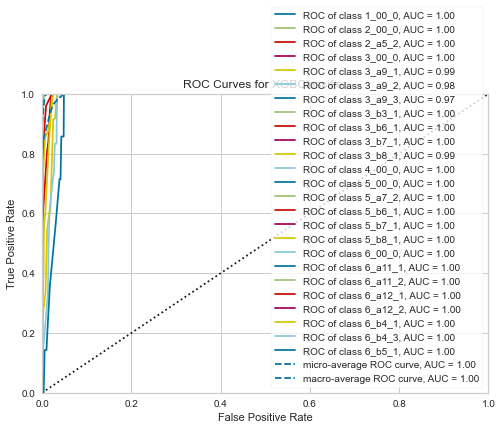

In [50]:
plot_model(tuned_top3[0], plot='auc')

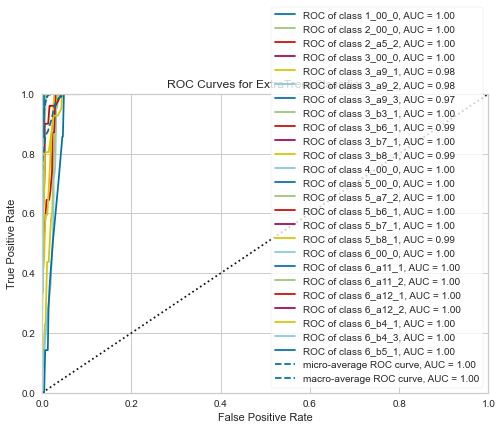

In [51]:
plot_model(tuned_top3[1], plot='auc')

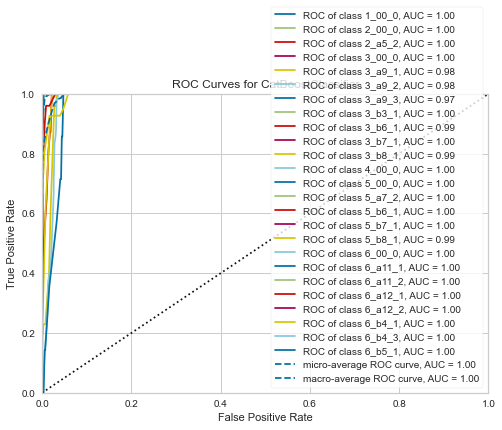

In [52]:
plot_model(tuned_top3[2], plot='auc')

# ensemble model

In [35]:
prediction_models=[]

In [48]:
xgb = create_model('xgboost')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9505,0.9991,0.8836,0.9376,0.9410,0.9440,0.9446
1,0.9480,0.9990,0.8917,0.9525,0.9461,0.9412,0.9415
2,0.9332,0.9985,0.8277,0.9315,0.9300,0.9243,0.9246
3,0.9554,0.9989,0.8574,0.9516,0.9528,0.9495,0.9496
4,0.9505,0.9991,0.8454,0.9446,0.9443,0.9440,0.9442
5,0.9406,0.9989,0.8703,0.9493,0.9406,0.9328,0.9330
6,0.9603,0.9994,0.8734,0.9703,0.9558,0.9550,0.9555
7,0.9380,0.9984,0.8651,0.9492,0.9366,0.9298,0.9301
8,0.9280,0.9985,0.8244,0.9293,0.9265,0.9185,0.9186
9,0.9553,0.9991,0.8748,0.9476,0.9471,0.9494,0.9500


In [49]:
bagging_xgb50 = ensemble_model(xgb, method='Bagging', n_estimators=50, choose_better=True,fold=5, optimize='F1', verbose=True)


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9530,0.9991,0.8812,0.9544,0.9480,0.9468,0.9471
1,0.9442,0.9987,0.8641,0.9446,0.9416,0.9369,0.9371
2,0.9467,0.9989,0.8717,0.9451,0.9425,0.9397,0.9399
3,0.9529,0.9990,0.8582,0.9668,0.9471,0.9467,0.9472
4,0.9430,0.9988,0.8404,0.9363,0.9378,0.9355,0.9358
Mean,0.9480,0.9989,0.8631,0.9494,0.9434,0.9411,0.9414
SD,0.0042,0.0001,0.0137,0.0104,0.0038,0.0048,0.0049


In [36]:
# bagging
# ensemble_model(model_et, method='Bagging', n_estimators=10, fold=5, round = 4, choose_better=True,optimize='F1', verbose=True)
bagging_xgb10 = ensemble_model(tuned_top3[0], method='Bagging', n_estimators=10, choose_better=True,fold=5, optimize='F1', verbose=True)
prediction_models.append(bagging_xgb10)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9517,0.9990,0.8612,0.9533,0.9466,0.9454,0.9457
1,0.9418,0.9987,0.8717,0.9459,0.9407,0.9341,0.9344
2,0.9467,0.9989,0.8713,0.9471,0.9433,0.9397,0.9400
3,0.9529,0.9989,0.8591,0.9587,0.9487,0.9467,0.9471
4,0.9430,0.9987,0.8404,0.9363,0.9378,0.9355,0.9358
Mean,0.9472,0.9988,0.8608,0.9482,0.9434,0.9403,0.9406
SD,0.0045,0.0001,0.0114,0.0075,0.0039,0.0051,0.0051


In [38]:
# boosting
boost_xgb = ensemble_model(tuned_top3[0], method="Boosting", fold=5, optimize='F1')
prediction_models.append(boost_xgb)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.1411,0.5000,0.0400,0.0199,0.0349,0.0000,0.0000
1,0.1400,0.5000,0.0400,0.0196,0.0344,0.0000,0.0000
2,0.1400,0.5000,0.0400,0.0196,0.0344,0.0000,0.0000
3,0.1400,0.5000,0.0400,0.0196,0.0344,0.0000,0.0000
4,0.1400,0.5000,0.0400,0.0196,0.0344,0.0000,0.0000
Mean,0.1402,0.5000,0.0400,0.0197,0.0345,0.0000,0.0000
SD,0.0004,0.0000,0.0000,0.0001,0.0002,0.0000,0.0000


In [ ]:
# # #blend
# blend_3_soft = blend_models(estimator_list=[tuned_top3[0],tuned_top3[1],tuned_top3[2]], , choose_better=True, method='soft', fold=5,optimize='F1',)
# prediction_models.append(blend_3_soft)

In [ ]:
# # stacking
# stack_3_soft = stack_models(estimator_list=[tuned_top3[0],tuned_top3[1],tuned_top3[2]], meta_model=model_et, fold=5,optimize='F1', choose_better=True)
# prediction_models.append(stack_3_soft)

In [ ]:
#voting?
# blend_model~

In [41]:
prediction = predict_model(data=X_test, estimator=bagging_xgb10)
prediction

,low_dew,mean_humi,humidity_95,high_humi,month,RH_95,high_dew,RH_70,temp_cond_1,RH_100,...,mean_temp,humidity_70,temp_cond_4,low_temp,mean_dew,temp_cond_2,humidity_80,low_humi,Label,Score
0,21.8,85.70,0.333333,100.0,7.000000,0.206186,29.1,0.419244,0.316151,0.134021,...,28.20,0.175258,0.075601,23.0,25.70,0.000000,0.178694,59.2,6_00_0,0.9997
1,7.8,84.50,0.000000,88.5,10.738095,0.000000,13.2,0.731293,0.064626,0.000000,...,12.80,0.122449,0.000000,10.4,10.10,0.527211,0.602041,53.7,5_b6_1,0.9946
2,13.9,83.55,0.000000,92.3,10.000000,0.000000,22.9,0.932432,0.324324,0.000000,...,19.25,0.175676,0.000000,18.1,16.35,0.000000,0.621622,56.6,4_00_0,0.9983
3,12.6,77.15,0.000000,93.6,9.000000,0.003401,20.6,0.571429,0.183673,0.000000,...,20.25,0.095238,0.000000,14.4,16.55,0.000000,0.234694,49.9,3_00_0,0.9997
4,7.8,83.05,0.000000,88.0,10.500000,0.000000,13.4,0.741497,0.064626,0.000000,...,12.60,0.119048,0.000000,10.4,9.80,0.544218,0.619048,54.7,3_b8_1,0.5975
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51901,13.9,89.90,0.003401,96.4,10.000000,0.098639,25.8,0.561224,0.102041,0.000000,...,18.70,0.030612,0.000000,15.4,16.45,0.000000,0.122449,37.0,4_00_0,0.9986
51902,1.7,83.70,0.000000,92.4,11.000000,0.000000,11.7,0.751701,0.000000,0.000000,...,9.40,0.098639,0.000000,4.9,6.60,0.710884,0.588435,40.2,3_b7_1,0.9974
51903,21.5,85.85,0.411565,100.0,7.000000,0.207483,30.6,0.193878,0.421769,0.207483,...,27.65,0.068027,0.343537,21.6,25.45,0.000000,0.074830,36.1,6_00_0,0.9992
51904,7.6,95.90,0.574830,99.0,10.000000,0.469388,33.2,0.428571,0.088435,0.061224,...,15.20,0.112245,0.020408,7.9,14.40,0.272109,0.139456,39.0,2_a5_2,0.9988


In [43]:
prediction2 = predict_model(data=X_test, estimator=best_models[0])
prediction2

,low_dew,mean_humi,humidity_95,high_humi,month,RH_95,high_dew,RH_70,temp_cond_1,RH_100,...,mean_temp,humidity_70,temp_cond_4,low_temp,mean_dew,temp_cond_2,humidity_80,low_humi,Label,Score
0,21.8,85.70,0.333333,100.0,7.000000,0.206186,29.1,0.419244,0.316151,0.134021,...,28.20,0.175258,0.075601,23.0,25.70,0.000000,0.178694,59.2,6_00_0,0.9998
1,7.8,84.50,0.000000,88.5,10.738095,0.000000,13.2,0.731293,0.064626,0.000000,...,12.80,0.122449,0.000000,10.4,10.10,0.527211,0.602041,53.7,5_b6_1,0.9951
2,13.9,83.55,0.000000,92.3,10.000000,0.000000,22.9,0.932432,0.324324,0.000000,...,19.25,0.175676,0.000000,18.1,16.35,0.000000,0.621622,56.6,4_00_0,0.9986
3,12.6,77.15,0.000000,93.6,9.000000,0.003401,20.6,0.571429,0.183673,0.000000,...,20.25,0.095238,0.000000,14.4,16.55,0.000000,0.234694,49.9,3_00_0,0.9998
4,7.8,83.05,0.000000,88.0,10.500000,0.000000,13.4,0.741497,0.064626,0.000000,...,12.60,0.119048,0.000000,10.4,9.80,0.544218,0.619048,54.7,3_b8_1,0.6148
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51901,13.9,89.90,0.003401,96.4,10.000000,0.098639,25.8,0.561224,0.102041,0.000000,...,18.70,0.030612,0.000000,15.4,16.45,0.000000,0.122449,37.0,4_00_0,0.9994
51902,1.7,83.70,0.000000,92.4,11.000000,0.000000,11.7,0.751701,0.000000,0.000000,...,9.40,0.098639,0.000000,4.9,6.60,0.710884,0.588435,40.2,3_b7_1,0.9971
51903,21.5,85.85,0.411565,100.0,7.000000,0.207483,30.6,0.193878,0.421769,0.207483,...,27.65,0.068027,0.343537,21.6,25.45,0.000000,0.074830,36.1,6_00_0,0.9996
51904,7.6,95.90,0.574830,99.0,10.000000,0.469388,33.2,0.428571,0.088435,0.061224,...,15.20,0.112245,0.020408,7.9,14.40,0.272109,0.139456,39.0,2_a5_2,0.9980


In [181]:
len(submission[submission.label=='-'])

40

In [74]:
save_model(final_model, 'Pycaret_et_crop_disease_220202', verbose=True)

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=False, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=['month', 'mean_temp',
                                                           'high_temp',
                                                           'low_temp',
                                                           'mean_humi',
                                                           'high_humi',
                                                           'low_humi',
                                                           'mean_dew',
                                                           'high_dew', 'low_dew',
                                                           'temp_cond_1',
                 

In [158]:
# print(f'temp_cond_1:{temp_cond_1}')
# print(f'temp_cond_2:{temp_cond_2}')
# print(f'temp_cond_3:{temp_cond_3}')
# print(f'temp_cond_4:{temp_cond_4}')
# print(f'humidity_70:{humidity_70}')
# print(f'humidity_80:{humidity_80}')
# print(f'humidity_90:{humidity_90}')
# print(f'humidity_95:{humidity_95}')
# print(f'humidity_100:{humidity_100}')
# print(f'RH_70:{RH_70}')
# print(f'RH_95:{RH_95}')
# print(f'RH_100:{RH_100}')
# print(f'month:{month}')

# b= pd.Series({'month':month,'temp_cond_1':temp_cond_1,'temp_cond_2':temp_cond_2,'temp_cond_3':temp_cond_3,'temp_cond_4':temp_cond_4,
#                     'humidity_70':humidity_70,'humidity_80':humidity_80,'humidity_90':humidity_90,'humidity_95':humidity_95,'humidity_100':humidity_100,
#                      'RH_70':RH_70,'RH_95':RH_95,'RH_100':RH_100})

temp_cond_1:0.5136054421768708
temp_cond_2:0.0
temp_cond_3:0.1326530612244898
temp_cond_4:0.0
humidity_70:0.08163265306122448
humidity_80:0.17346938775510204
humidity_90:0.2619047619047619
humidity_95:0.09863945578231292
humidity_100:0.0
RH_70:0.5238095238095238
RH_95:0.06802721088435375
RH_100:0.027210884353741496
month:8


## 포도노균병
- 균사 생육온도 5∼21℃, 
- 분생포자 발아적온 **20∼22℃ **
- 발병조건 : 고온 다습
- 분생포자 형성 환경 : 기온 12℃, 습도 95∼100%
- 분생포자, 난포자 발아 적온 : 20∼25℃
- 주로 습기가 많고, 그늘지고, 통풍이 불량한 과원에서 많이 발병

## 포도탄저병
- 5월 월동 병반에서 분생포자 형성, 강우로 미숙과에서 분산, 전파 - 생육온도 7∼37℃, 발병적온 28℃
- 고온 다습(성숙기) 포도에 치명적인 피해

## 포도흰가루
- 고온건조(개화기부터 10월 상순)
- 최저 15℃, 최적 25∼30℃, 70%이상
- 특히 13℃ 이하의 저온, 32℃ 이상의 고온 병의 진전 둔화
- 5월 중순부터 발병하여 6∼7월에 많이 발병
- 특히 이른봄부터 여름사이에 기온이 높은 해에 심하게 발병

## 포도일소피해
- 과립온도 35℃이상이면 호흡이상으로 과실내 알데히드 축적, 세포가 죽음으로써 발생

## 포도 축과병
- 직사광선이 강하게 닿지 않는 과방의 속이나 아랫부분에 발생
- 장마기 또는 직후 온도 및 토양수분의 변화가 급격히 일어나 수분흡수와 증산의 균형이 깨져 일어남
- 비가 내린후 맑은 날씨가 되었을 때 심하게 발생


In [85]:
train_csv[0]

'C:/Users/jeong/Projects/dacon/병해진단/data/train\\10027\\10027.csv'

In [68]:
csv_data[0].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588 entries, 0 to 587
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   측정시각        588 non-null    object 
 1   내부 온도 1 평균  588 non-null    float64
 2   내부 온도 1 최고  588 non-null    float64
 3   내부 온도 1 최저  588 non-null    float64
 4   내부 습도 1 평균  588 non-null    float64
 5   내부 습도 1 최고  588 non-null    float64
 6   내부 습도 1 최저  588 non-null    float64
 7   내부 이슬점 평균   588 non-null    float64
 8   내부 이슬점 최고   588 non-null    float64
 9   내부 이슬점 최저   588 non-null    float64
dtypes: float64(9), object(1)
memory usage: 46.1+ KB


In [ ]:
crop_dict = {1:'딸기', 
             2:'토마토',
             3:'파프리카',
             4:'오이', 
             5:'고추',
             6: '시설포도'}

area_dict = {1:'열매',
             2:'꽃',
             3:'잎',
             4:'가지',
             5:'줄기',
             6:'뿌리',
             7:'해충'}

task_dict = {0:'정상',
             1:'병해',
             2:'생리장애',
             3:'보호제처리반응'}

disease_dict = {'00' : '정상',
                
                # 병해 a
                'a1' : '딸기잿빛곰팡이병',
                'a2' : '딸기흰가루병',
                'a3' : '오이노균병',
                'a4' : '오이흰가루병',
                'a5' : '토마토흰가루병',
                'a6' : '토마토잿빛곰팡이병',
                'a7' : '고추탄저병',
                'a8' : '고추흰가루병',
                'a9' : '파프리카흰가루병',
                'a10' : '파프리카잘록병',
                'a11' : '시설포도탄저병',
                'a12' : '시설포도노균병',
                
                # 생리장애 b
                'b1' : '냉해피해',
                'b2' : '열과',
                'b3' : '칼슘결핍',
                'b4' : '일소피해',
                'b5' : '축과병',
                'b6' : '다량원소결핍 (N)',
                'b7' : '다량원소결핍 (P)',
                'b8' : '다량원소결핍 (K)',
                
                # 보호제 처리반응 c
                'c1' : '딸기잿빛곰팡이병반응',
                'c2' : '딸기흰가루병반응',
                'c3' : '오이노균병반응',
                'c4' : '오이흰가루병반응',
                'c5' : '토마토흰가루병반응',
                'c6' : '토마토잿빛곰팡이병반응',
                'c7' : '고추탄저병반응',
                'c8' : '고추흰가루병반응',
                'c9' : '파프리카흰가루병반응',
                'c10' : '파프리카잘록병반응',
                'c11' : '시설포도탄저병반응',
                'c12' : '시설포도노균병반응'
               }

            # 시설 과채류
grow_dict = {11:'유묘기',
             12:'생장기',
             13:'착화/과실기',
             
             # 시설 과수류 (포도)
             21:'발아기',
             22:'개화기',
             23:'신초생장기',
             24:'과실성숙기',
             25:'수확기',
             26:'휴면기'}

risk_dict = {0:'정상',
             1:'초기',
             2:'중기',
             3:'말기'}